# Sentiment Based Product Recommendation
                                                                                                                                            - Rony Lizzy Sunny

**Webapp Link**:  https://sentiment-based-recommend.herokuapp.com/

In [45]:
import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import pairwise_distances
from imblearn.over_sampling import SMOTE



In [5]:
df = pd.read_csv("sample30.csv")

# Removing the rows where user_sentiment and reviews title are Nans
# These two columns are the most important columns for sentiment analysis
df = df[~(df['user_sentiment'].isna())]
df = df[~(df['reviews_title'].isna())]

# checking for missing values
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     13877
reviews_doRecommend      2404
reviews_rating              0
reviews_text                0
reviews_title               0
reviews_userCity        27881
reviews_userProvince    29642
reviews_username           62
user_sentiment              0
dtype: int64

/home/ron/anaconda3/envs/DS/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1]), [Text(0, 0, 'Positive'), Text(1, 0, 'Negative')])

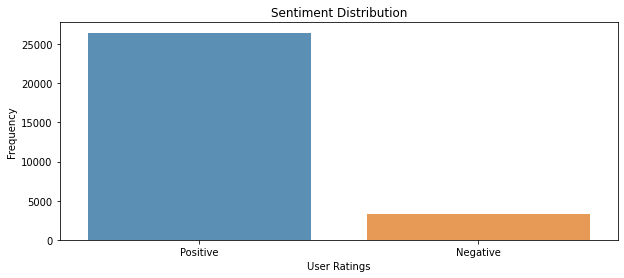

In [19]:
# As we can see that the data is imbalance, we will deal with this later.
x_rating = df['user_sentiment'].value_counts()
y_rating = x_rating.sort_index()

plt.figure(figsize=[10,4])
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Sentiment Distribution")
plt.ylabel('Frequency')

plt.xlabel('User Ratings')
plt.xticks()


Text(0, 0.5, 'Ratings')

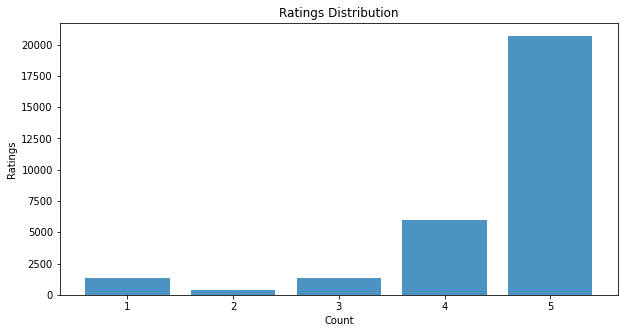

In [22]:
#plot ratings frequency
plt.figure(figsize=[10,5])
x_rating = df['reviews_rating'].value_counts()
y_rating = x_rating.sort_index()
plt.bar(x_rating.index, x_rating.values, alpha=0.8)

plt.title('Ratings Distribution')
plt.xlabel('Count')
plt.ylabel('Ratings')

In [23]:
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [30]:
lemmatizer = WordNetLemmatizer()


In [32]:
df['lemmatized'] = df['reviews_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])

In [33]:
df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['reviews_text'].astype(str).apply(len)

# Checking the relation between ratings and len of reviews
- Lower ratings have more words

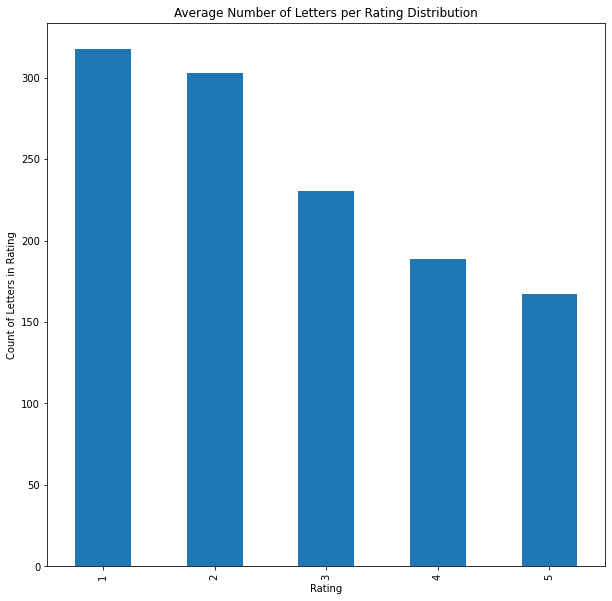

In [35]:

letter_avg = df.groupby('reviews_rating')['review_len'].mean().plot(kind='bar', figsize=(10, 10))
plt.xlabel('Rating')
plt.ylabel('Count of Letters in Rating')
plt.title('Average Number of Letters per Rating Distribution')
plt.show()

<AxesSubplot:>

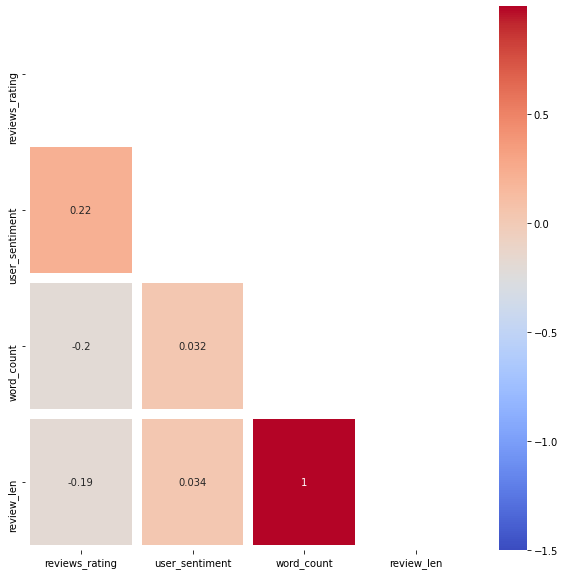

In [39]:
correlation = df[['reviews_rating','user_sentiment', 'word_count', 'review_len']].replace({"Positive":1, "Negative":0}).corr()
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))

sns.heatmap(correlation, cmap='coolwarm', annot=True, linewidths=10, vmin=-1.5, mask=mask)


In [4]:
# df = df[~(df['reviews_username'] == "byamazon customer")]

In [51]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
# print(allwords)
stop_words = set(stopwords.words('english')) 
allwords = [word for word in allwords if word not in stop_words]

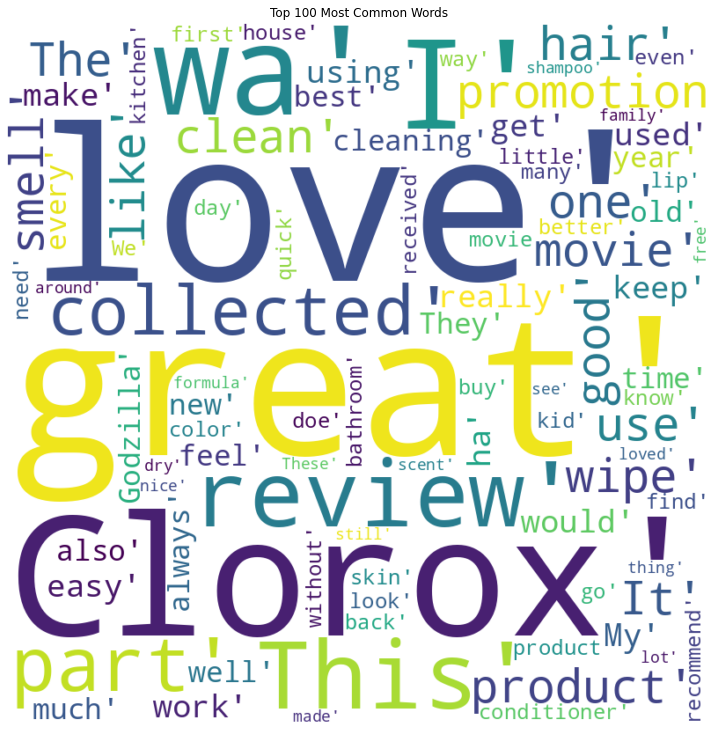

In [52]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words')
plt.tight_layout(pad=0)
plt.show()

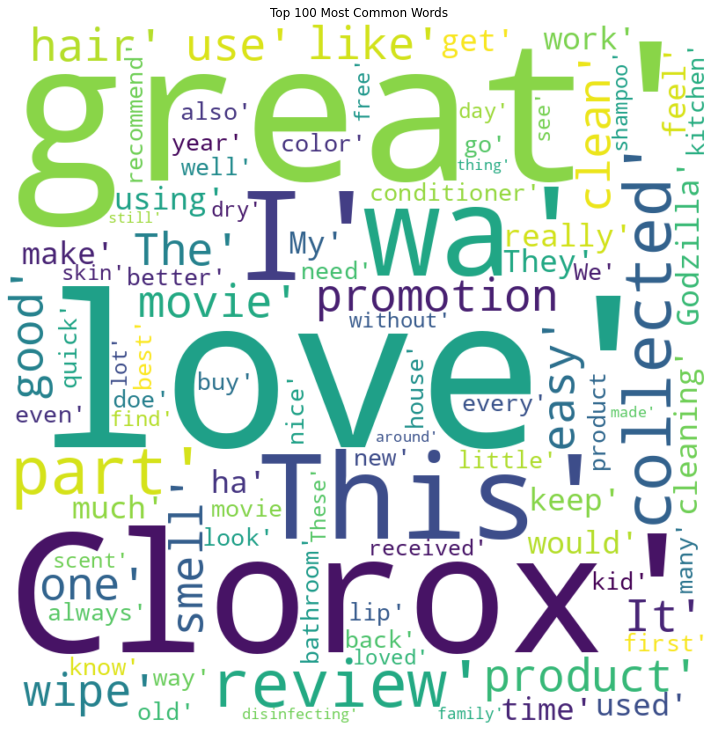

In [53]:
# Checking for words that are more prominent in Positive Reviews
# Words that we expect like great love etc do occur in great numbers


words = df[df['user_sentiment']=="Positive"]['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
# print(allwords)
stop_words = set(stopwords.words('english')) 
allwords = [word for word in allwords if word not in stop_words]

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words')
plt.tight_layout(pad=0)
plt.show()

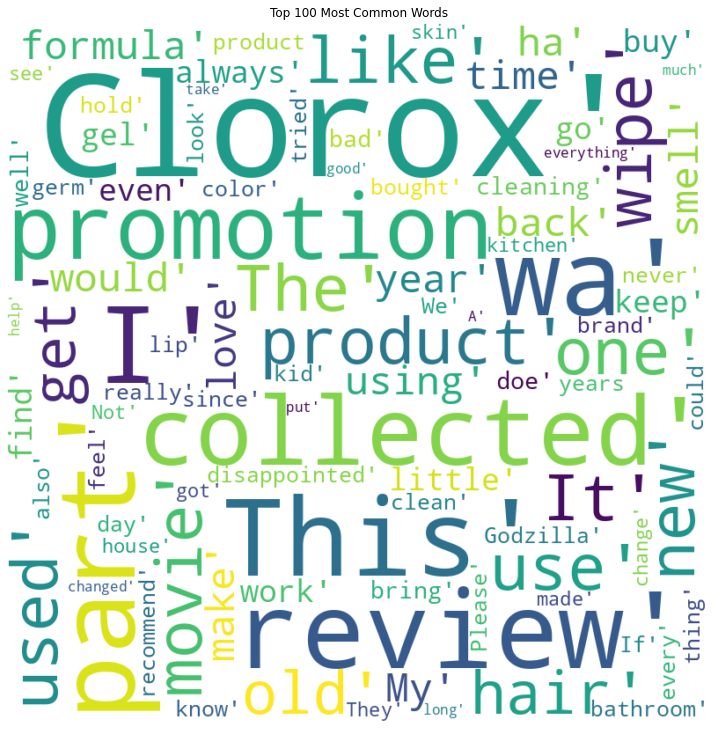

In [54]:
# Checking for words that are more prominent in Negative Reviews
# Strangly there are no negative show up here 


words = df[df['user_sentiment']=="Negative"]['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
# print(allwords)
stop_words = set(stopwords.words('english')) 
allwords = [word for word in allwords if word not in stop_words]

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words')
plt.tight_layout(pad=0)
plt.show()

In [6]:
df[df['user_sentiment']=='Negative']['reviews_title']

3                                            Disappointed
4                                              Irritation
5                                            Not worth it
6                                           Disappointing
7                                        Not happy at all
                               ...                       
29818                                       Great Product
29855                                               Great
29858    Makes my hair soft and shiny without excess oil!
29862                                   Great Conditioner
29941     Good for keeping combination hair under control
Name: reviews_title, Length: 3339, dtype: object

In [7]:
# the below sentence occured in nearly 30% of the reviews, hence replaced it with blank

df['check'] = df['reviews_text'].apply(lambda x: "Yes" if " This review was collected as part of a promotion." in x else "No")
df['check'].value_counts(normalize=True)

No     0.706396
Yes    0.293604
Name: check, dtype: float64

In [8]:

df['reviews_text'] = df['reviews_text'].replace({" This review was collected as part of a promotion." : ""})


In [9]:
# X = df['reviews_title'] + " " +df['reviews_text'] 
# Ran the Model with both and the one with only reviews_text gave better results.
X = df['reviews_text']
y = df['user_sentiment']


In [10]:
# Getting a set of stopwords from the nltk library.
# the nltk library has a included a lot of negation words.
# we would manually remove these words.
stop_words = set(stopwords.words('english')) 
print(stop_words)
print(len(stop_words))

{'wouldn', 'now', 'ma', 'after', 'against', 'off', 'again', 'so', 'too', 'will', 'all', 'because', 'once', 'she', 'his', "isn't", 'i', "needn't", 'yourselves', 'we', 've', 'any', 'to', 'haven', 'this', 'each', 'couldn', 'hadn', "wasn't", 'who', 'in', 'no', 'between', 'other', 'should', 'if', 'own', 'as', "you'll", 'most', "you're", 'at', 'is', 'up', 'during', 'do', 'over', 's', 'or', 'only', 'doing', 'm', 'll', 'and', 'had', 'isn', 'on', 'under', 'did', "that'll", 'have', 'with', "didn't", 'my', 'are', 'about', 'the', 'ours', 'into', 'our', 'it', 'through', 'a', 'until', 'for', 'their', 'he', 'those', 'itself', 'being', "doesn't", "you've", 'such', 'theirs', 'me', "shouldn't", 'very', 'myself', 'what', 'her', 'few', 't', 'does', 'above', 'here', "it's", 'be', "couldn't", 'when', 'hasn', "should've", 'weren', "mustn't", 'themselves', 'yourself', 'him', 'd', "mightn't", "you'd", 'was', 'nor', "don't", 'some', 'your', 'am', "shan't", 'were', 'needn', "she's", 'where', 'mightn', 'an', "hav

In [11]:
# After removing and adding few other words.
custum_stopwords = {'too', 'so', 'they', 'u', 'it', 'oly', 'itself', 'yours', 'rt', 'between', 'where', 'but', 'he', 'now', 'org', 'over', 'o', 'being', 'most', 'with', 'below', 'off', 'up', 'or', 'that', 'about', "should've", 
'r', 'yourself', 'what', 'any', 'by', "you'll", 'few', "you've", 'not', 'y', 'does', 'she', "it's", 'ourselves', 'only', 'both', 'of', 'b', 'after', 'those', 'we', "that'll", 'be', 'ht', 'd', 'out', 'will', 'at', 'there', 'were',
'when', 'am', 've', 'having', 'her', 'all', 'its', 'th', 'than', 'which', 'today', "she's", 'hw', 'then', 'should', 'if', 'edu', 'and', 'the', 'as', 'n', 'through', 'them', 'also', 'because', 'further', 'against', "you're", 'how',
'who', 'was', 'some', 'own', 'before', "you'd", 'com', 'himself', 'again', 'll', 'these', 'myself', 'been', 'for', 'yourselves', 'has', 'this', 'ax', 'had', 'on', 'p', 'm', 'in', 's', 'wat', 'from', 'each', 'i', 'our', 'an',
'are', 'their', 'would', 'you', 'more', 'his', 'have', 'while', 'other', 'last', 'until', 'once', 'do', 'can', 'why', 'ours', 'just', 'like', 'doing', 'whom', 'subject', 'says', 'a', 'your', 't', 'him', 'here', 'told', 
'themselves', 'hers', 'my', 'same', 'under', 'above', 'such', 'very', 'me', 'to', 'theirs', 'during', 'is', 'ma', 'lines', 'into', 'did', 'one', 'herself', 'said', 're', 'likes'}


len(custum_stopwords)

166

In [12]:
# Downloading a list of contractions and their expanded words from wikipedia.
contractions = pd.read_html("https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions#:~:text=Wikipedia%3AList%20of%20English%20contractions%20%20%20%20Contraction,not%20you%20%28colloquial%29%20%2097%20more%20rows%20")
contractions = contractions[1]

# Cleaning the DataFrame.
lis = contractions.Meaning.tolist()
lis = [x.split("/")[0] for x in lis]
lis = [x.split("(")[0].strip() for x in lis]
lis = [x.split("[")[0] for x in lis]
lis = [x.split(",")[0] for x in lis]

contractions['Meaning'] = lis

contractionLis = contractions['Contraction'].tolist()
meanings = contractions['Meaning'].tolist()

# adding a few more terms like show below, for better text processing
contractionsDict = dict(zip(contractionLis, meanings))
contractionsDict[" u "] = " you "
contractionsDict[" ur "] = " your "
contractionsDict[" n "] = " and "
contractionsDict[" nd "] = " and "

print(contractionsDict)

{"a'ight": 'alright', "ain't": 'am not', "amn't": 'am not', 'arencha': 'aren’t you', "aren't": 'are not', '‘bout': 'about', 'cannot': 'can not', "can't": 'cannot', 'cap’n': 'captain', "'cause": 'because', '’cept': 'except', "could've": 'could have', "couldn't": 'could not', "couldn't've": 'could not have', 'dammit': 'damn it', "daren't": 'dare not', "daresn't": 'dare not', "dasn't": 'dare not', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', 'dunno': "don't know", "d'ye": 'do you', "e'en": 'even', "e'er": 'ever', "'em": 'them', "everybody's": 'everybody is', "everyone's": 'everyone is', 'fo’c’sle': 'forecastle', '’gainst': 'against', "g'day": 'good day', 'gimme': 'give me', "giv'n": 'given', 'gonna': 'going to', "gon't": 'go not', 'gotta': 'got to', "hadn't": 'had not', "had've": 'had have', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he had', "he'll": 'he shall', 'helluva': 'hell of a', "he's": 'he has', "here's": 'here is', "how'd": 'how did', 'howdy': 'how do

In [13]:
# Function to expand the contraction.
def expand_contractions(x):
    if type(x) is str:
        x = x.replace("\\", "")
        for key in contractionsDict:
            value = contractionsDict[key]
            x = x.replace(key, value)
        return x
    else:
        return x 

In [14]:
y.isnull().value_counts()

False    29768
Name: user_sentiment, dtype: int64

In [15]:
expand_contractions(X[0])

'i love this album. it has very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.'

In [16]:
X.str.lower()

0        i love this album. it's very good. more to the...
1        good flavor. this review was collected as part...
2                                             good flavor.
3        i read through the reviews on here before look...
4        my husband bought this gel for us. the gel cau...
                               ...                        
29995    i got this conditioner with influenster to try...
29996    i love it , i received this for review purpose...
29997    first of all i love the smell of this product....
29998    i received this through influenster and will n...
29999    i received this product complimentary from inf...
Name: reviews_text, Length: 29768, dtype: object

In [17]:
X = X.apply(lambda x: expand_contractions(x))

In [19]:
# Custum preprocessing function

def preProcessing(X):
    X = X.replace(r'<ed>','', regex = True)# remove emoticons form the tweets
    X = X.replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)# convert tweets to lowercase
    X = X.replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)# replacing with blanks
    X = X.replace("  ", " ")# replacing double blanks with single blank
    X = X.replace(r'^(@\w+)',"", regex=True)#remove user mentions
    X = X.replace(r'[^a-zA-Z0-9]', " ", regex=True)#remove_symbols
    X = X.replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+',"", regex = True)#remove punctuations 
    X = X.replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)#remove words of length 1 or 2 
    X = X.replace(r'^\s+|\s+$'," ", regex=True) #remove extra spaces in the tweet

    #removing stopwords using the custum stopwords.
    X = X.apply(lambda x: " ".join([token for token in x.split() if token not in custum_stopwords]))

    punctuations = string.punctuation
    # removing extra punctuations from string module
    X = X.apply(lambda x: " ".join([token for token in x.split() if token not in punctuations]))
    #converting to lower string
    X = X.str.lower()
    return X

In [20]:
X = preProcessing(X)

# Encoding positive and negative to 0 and 1
y = y.replace({"Positive":1, "Negative":0})

C:\Users\srony\anaconda3\envs\DS\lib\site-packages\pandas\core\dtypes\inference.py:178: FutureWarning: Possible nested set at position 1
  re.compile(obj)


In [21]:
X

0        love album good hip hop side current pop sound...
1        good flavor this review collected part promoti...
2                                              good flavor
3        read reviews looking buying couples lubricants...
4        husband bought gel the gel caused irritati don...
                               ...                        
29995    got conditi donter influenster try loving far ...
29996    love received review purposes influenster leav...
29997    first love smell product after wash hair smoot...
29998    received influenster never back anything else ...
29999    received product complimentary influenster rea...
Name: reviews_text, Length: 29768, dtype: object

In [22]:
# def custumTokenizer(sentence):
#     # Load English tokenizer, tagger, parser, NER and word vectors
#     parser = spacy.load("en_core_web_sm")

#     # Creating our token object, which is used to create documents with linguistic annotations.
#     mytokens = parser(sentence)

#     # # Lemmatizing each token and converting each token into lowercase
#     # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

#     # Create our list of punctuation marks
#     punctuations = string.punctuation
#     # Create our list of stopwords
    
#     # Removing stop words
#     mytokens = [ word for word in mytokens if word not in custum_stopwords and word not in punctuations ]

#     # return preprocessed list of tokens
#     return mytokens




# tf-idf vectorizer to vectorize the reviews_text to create a feature vector.
# tried bag of words vector and tf-idf performed better.    
tf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    token_pattern=r'\w{1,}',
    analyzer='word',
    ngram_range=(1,3),
    stop_words='english',
    max_features=50000,
)

tf_vectorizer.fit(X)
tokenizedFeatures = tf_vectorizer.transform(X)



In [23]:
# Splitting the dataset into train and test.
# 70% train and 30% test.
X_train, X_test, y_train, y_test = train_test_split(tokenizedFeatures, y, shuffle=True,test_size=0.3, random_state=100)


In [24]:
y_train.head()

9905     1
2584     0
3564     1
21509    1
17730    1
Name: user_sentiment, dtype: int64

In [25]:
# As mentioned earlier our dataset is not balanced.
# The problem with imbalanced dataset is that one or set of classes will dominate the others.
# This will cause the ML models to be more biased towards the classes with more occurances.
# we will be using the SMOTE to balance the sample, where it will sytheticaly create more neg samples. 

# SMOTE: Synthetic Minority Oversampling Technique
# SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

sampler = SMOTE()
X_train_SMOTE, y_train_SMOTE = sampler.fit_resample(X_train, y_train)

In [26]:
np.logspace(-4, 4, 10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [27]:
#Building a model for logistic regression using gridserachCV
def build_model_logistic(X_train, y_train, X_test, y_test, cv=True, nsplits=5, random_state=100, save=False):
    time1 = time.time()
    classifier = LogisticRegression(max_iter=1000, solver='liblinear')

    stratified_kfold = StratifiedKFold(n_splits=nsplits,
                                        shuffle=True,
                                        random_state=random_state)

    param_grid = {'C': [17,20,224,26,28,30],
                "penalty":["l1","l2","elastic"]}

    grid_search = GridSearchCV(estimator=classifier,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv=stratified_kfold,
                            n_jobs=-1)

    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)

    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

    print("Logistic Regression accuracy", accuracy_score(predictions, y_test))
    print(classification_report(predictions, y_test))
    print("Best Params: ", grid_search.best_params_)

    plot_confusion_matrix(grid_search, X_test, y_test)

    time_taken = time.time() - time1
    print('Time taken: {:.2f} seconds'.format(time_taken))




# Logistic Regression.

- the Accuracy of the model is good though the precision is not up to the mark.
- Precision is important as we dont want to recommend negatively rated products to the user.
- only 68% true negatives, we should look for a model thats able to give us more true negatives.
- precision on the positive lavels are way higher as the number of positives are really high, and if the model predicted everything as positive we will still get an okish accuracy.
- but thats not our goal here.



C:\Users\srony\anaconda3\envs\DS\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.99164385 0.9957971         nan 0.9915542  0.99585351        nan
 0.9918108  0.99609511        nan 0.99145632 0.99592615        nan
 0.99144336 0.99593801        nan 0.99143832 0.99594965        nan]
  warnings.warn(


Cross-validation score: 0.9960951149247939
Test score: 0.9481162945077181
Logistic Regression accuracy 0.923300862165491
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      1043
           1       0.95      0.96      0.96      7888

    accuracy                           0.92      8931
   macro avg       0.82      0.80      0.81      8931
weighted avg       0.92      0.92      0.92      8931

Best Params:  {'C': 224, 'penalty': 'l2'}
Time taken: 9.31 seconds


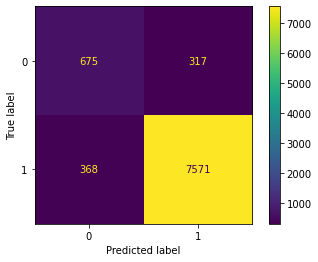

In [28]:
#Running the model.
build_model_logistic(X_train_SMOTE,y_train_SMOTE,X_test, y_test)

# XGBoost

- We will be selecting XGBoost as our model
- As it gave the best precision.
- Accuracy of the model is lesser that logistic regression.
- But still the precision is higher with 87 % of the actual negatives being predicted and negatives.
- This will help the recommendation system in not recommending bad products, even though we might miss out on a few good products.

In [33]:
def build_model_XGBoost(X_train, y_train, X_test, y_test, cv=True, nsplits=5, random_state=100, save=False):
    time1 = time.time()
    classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        seed=random_state
        )

    stratified_kfold = StratifiedKFold(n_splits=nsplits,
                                        shuffle=True,
                                        random_state=random_state)

    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100],
        'objective': ['reg:squarederror']
        }

    grid_search = GridSearchCV(estimator=classifier,
                            param_grid=param_grid,
                            scoring='f1',
                            cv=stratified_kfold,
                            n_jobs=-1)

    grid_search.fit(X_train, y_train, verbose=True)
    predictions = grid_search.predict(X_test)
    cv_score = grid_search.best_score_
    # test_score = grid_search.score(X_test, y_test)

    # print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

    print("XGBoost accuracy", accuracy_score(predictions, y_test))
    print(classification_report(predictions, y_test))
    plot_confusion_matrix(grid_search, X_test, y_test)
    print("Best Params: ", grid_search.best_params_)

    time_taken = time.time() - time1
    print('Time taken: {:.2f} seconds'.format(time_taken))

    if save==True:
        joblib_file = "xgbModel.pkl"
        joblib.dump(grid_search, joblib_file)
    
    return grid_search



C:\Users\srony\anaconda3\envs\DS\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Logistic Regression accuracy 0.8941887806516627
              precision    recall  f1-score   support

           0       0.87      0.51      0.65      1679
           1       0.90      0.98      0.94      7252

    accuracy                           0.89      8931
   macro avg       0.88      0.75      0.79      8931
weighted avg       0.89      0.89      0.88      8931

Best Params:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.7}
Time taken: 1417.77 seconds


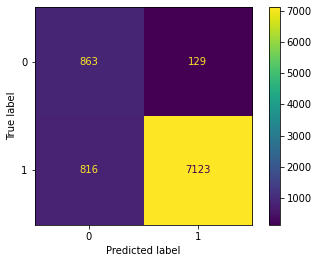

In [34]:
grid_search = build_model_XGBoost(X_train_SMOTE, y_train_SMOTE,X_test, y_test)

In [35]:
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=100,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
      

# Saving the model, which will be used in the model.py file.

In [37]:
# importing joblib module to save the model.
import joblib
joblib_file = "xgbModel.pkl"
joblib.dump(grid_search, joblib_file)

['xgbModel.pkl']

In [38]:
X_test

<8931x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 219270 stored elements in Compressed Sparse Row format>

In [39]:
# Testing if the model is performing
model = joblib.load("xgbModel.pkl")
preds = model.predict(X_test)

In [96]:
# Building the randomforest classifier.
def build_model_RandomForest(X_train, y_train, X_test, y_test, cv=True, nsplits=15, random_state=100, save=False):
    time1 = time.time()
    classifier = RandomForestClassifier(criterion='gini')

    stratified_kfold = StratifiedKFold(n_splits=nsplits,
                                        shuffle=True,
                                        random_state=random_state)

    param_grid = {
        'bootstrap': [True],
        'max_depth': [50, 55, 60, 65],
        # "criteion" : ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 3, 4, 5,6],
        'min_samples_split': [4, 6, 8, 10],
    #'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    
        'n_estimators': [125 , 130, 135, 140, 145]
        }

    grid_search = RandomizedSearchCV(estimator=classifier,
                            param_distributions=param_grid,
                            scoring='f1',
                            cv=stratified_kfold,
                            n_jobs=-1,
                            random_state=random_state)

    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    cv_score = grid_search.best_score_
    # test_score = grid_search.score(X_test, y_test)

    # print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

    print("Random Forest accuracy", accuracy_score(predictions, y_test))
    print(classification_report(predictions, y_test))
    print("Best Scores: ", grid_search.best_score_)
    print("Best Params: ", grid_search.best_params_)
    plot_confusion_matrix(grid_search, X_test, y_test)

    time_taken = time.time() - time1
    print('Time taken: {:.2f} seconds'.format(time_taken))

Logistic Regression accuracy 0.8719068413391557
              precision    recall  f1-score   support

           0       0.63      0.45      0.52      1394
           1       0.90      0.95      0.93      7537

    accuracy                           0.87      8931
   macro avg       0.76      0.70      0.72      8931
weighted avg       0.86      0.87      0.86      8931

Best Scores:  0.9083968135074749
Best Params:  {'n_estimators': 135, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
Time taken: 282.89 seconds


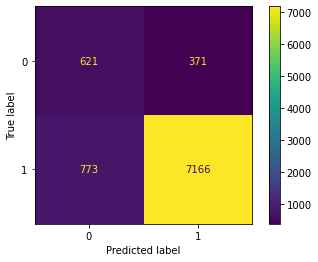

In [97]:
build_model_RandomForest(X_train_SMOTE, y_train_SMOTE,X_test, y_test)

In [54]:
time1 = time.time()
classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=8, n_jobs=-1)
classifier.fit(X_train_SMOTE, y_train_SMOTE)
preds1 = classifier.predict(X_test)

time_taken = time.time() -time1
print('Time taken: {:.2f} seconds'.format(time_taken))

Time taken: 5.01 seconds


              precision    recall  f1-score   support

           0       0.47      0.62      0.53       743
           1       0.96      0.94      0.95      8200

    accuracy                           0.91      8943
   macro avg       0.72      0.78      0.74      8943
weighted avg       0.92      0.91      0.92      8943



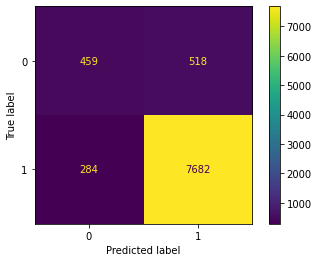

In [55]:
print(classification_report(preds1, y_test))
plot_confusion_matrix(classifier, X_test, y_test)

# Recommendation System

To DO:

- User Based Recommendation System
- Item Based Recommendation System
- Choose Cosine similarity or Adjusted similarity
- Choose Between User or Item Based Recommendation System based on RMSE score

In [56]:
# Reading the files
df = pd.read_csv("sample30.csv")

In [57]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [62]:
ratings = df[['reviews_username','name', 'reviews_rating']]
ratings.columns = ['userId', 'prodId', 'rating']
ratings = ratings.dropna()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [64]:
len(ratings['userId'].unique().tolist())

24914

In [65]:
ratings = ratings.groupby(['userId', 'prodId']).mean().reset_index()
ratings

,userId,prodId,rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),1.0
2,00sab00,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,3.0
3,01impala,Godzilla 3d Includes Digital Copy Ultraviolet ...,3.0
4,02dakota,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.0
...,...,...,...
27583,zxcsdfd,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
27584,zxjki,Clorox Disinfecting Wipes Value Pack Scented 1...,2.0
27585,zyiah4,Clorox Disinfecting Wipes Value Pack Scented 1...,5.0
27586,zzdiane,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5.0


In [66]:
train, test = train_test_split(ratings, test_size=0.30, random_state=30)

In [67]:
print(train.shape)
print(test.shape)

(19311, 3)
(8277, 3)


In [68]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot(
    index='userId',
    columns='prodId',
    values='rating'
).fillna(0)

df_pivot.head(10)

prodId,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
userId,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.11E+24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10ten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.


In [71]:
dummy_train = train.copy()

In [72]:
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>0 else 1)
dummy_train

,userId,prodId,rating
17619,mimi3,Clorox Disinfecting Wipes Value Pack Scented 1...,0
13956,kingkai650,The Resident Evil Collection 5 Discs (blu-Ray),0
3926,byirene chae,"Lundberg Wehani Rice, 25lb",0
3017,bobdigi,Nexxus Exxtra Gel Style Creation Sculptor,0
26636,vianca6,Clorox Disinfecting Wipes Value Pack Scented 1...,0
...,...,...,...
500,advichiel,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0
12077,jimbus,Nexxus Exxtra Gel Style Creation Sculptor,0
15277,lisa zaslow,"Pendaflex174 Divide It Up File Folder, Multi S...",0
4517,carmen b,Clorox Disinfecting Wipes Value Pack Scented 1...,0


In [73]:
dummy_train = dummy_train.pivot(
    index='userId',
    columns='prodId',
    values='rating'
).fillna(1)

In [74]:
trial = dummy_train.sum(axis=1).reset_index()
trial.columns = ['userId', 'NoRatings']
trial.max()

userId       zzz1127
NoRatings      253.0
dtype: object

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.

In [82]:
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)]=0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


# Adjusted Cosine

In [83]:
# df_pivot = train.pivot(
#     index='userId',
#     columns='prodId',
#     values='rating'
# )

In [84]:
# df_pivot.head()

In [85]:
# mean = np.nanmean(df_pivot, axis=1)
# df_substracted = (df_pivot.T - mean).T

In [86]:
# df_substracted.head()

In [87]:
# user_correlation = 1 - pairwise_distances(df_substracted.fillna(0), metric='cosine')
# user_correlation[np.isnan(user_correlation)]=0
# print(user_correlation)

In [88]:
# user_correlation.min()



Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

We will be using Cosine Similarity, as it gave better rmse score.
the reson for this might be since we hace a lot of user who have only rated a single time.
in such cases the similarity score will be zero. as the average of 1 substracted with the users rating 1 is zero.

In [89]:
user_correlation[user_correlation<0]=0
user_correlation.shape

(17844, 17844)

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [90]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  3.60798171,  0.        , ..., 12.29726806,
         0.        ,  0.61084722],
       [ 0.        , 21.14607926,  0.        , ..., 26.13335793,
         2.21348628,  3.61215302],
       ...,
       [ 0.        ,  6.82742743,  0.        , ...,  8.42825742,
         2.88675135,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.80421959,
         2.49017207,  1.06066017],
       [ 0.        ,  6.82742743,  0.        , ...,  8.42825742,
         2.88675135,  0.        ]])

In [91]:
user_predicted_ratings.shape

(17844, 254)

Since we are interested only in the Products not rated by the user, we will ignore the Products rated by the user by making it zero.

In [92]:
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

prodId,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
userId,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.461830,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
00sab00,0.0,3.607982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.173706,...,0.000000,0.0,2.981424,1.370578,0.0,0.0,0.0,12.297268,0.000000,0.610847
01impala,0.0,21.146079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.823750,...,2.213486,0.0,2.404485,1.599007,0.0,0.0,0.0,26.133358,2.213486,3.612153
0325home,0.0,6.827427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.980429,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,8.428257,2.886751,0.000000
06stidriver,0.0,6.827427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.980429,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,8.428257,2.886751,0.000000


# Finding Top recommendations for the user

In [96]:
user_input = "memyself2"

In [97]:
user_final_rating.to_csv("recom.csv")

In [98]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)
d

prodId
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    78.925994
Mike Dave Need Wedding Dates (dvd + Digital)                           78.353213
The Resident Evil Collection 5 Discs (blu-Ray)                         69.229581
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                   45.895652
Red (special Edition) (dvdvideo)                                       39.365023
                                                                         ...    
Iman Luxury Moisturizing Lipstick, Black Brandy 006                     0.000000
Iman Second To None Stick Foundation, Clay 1                            0.000000
J.R. Watkins Hand Cream, Lemon Cream                                    0.000000
J.a. Henckels International 4-Pc Everedge Plus Steak Knife Set          0.000000
La Tortilla Factory Hand Made Style Tortillas Flour                     0.000000
Name: memyself2, Length: 254, dtype: float64

# Evaluation User Based Recommendation System

In [99]:
common = test[test['userId'].isin(train['userId'])]
common.shape

(1059, 3)

In [100]:
common['userId'].value_counts()

mike        7
lisa        6
mimi        5
jenn        5
rick        4
           ..
roger       1
liss77      1
kimmi       1
nguyet11    1
bruce       1
Name: userId, Length: 893, dtype: int64

In [101]:
common_user_based_matrix = common.pivot(index='userId', columns='prodId', values='rating')
common_user_based_matrix.shape

(893, 119)

In [102]:
common_user_based_matrix

prodId,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",...,Tostitos Simply Blue Corn Tortilla Chips,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zippy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
user_correlation_df = pd.DataFrame(user_correlation)

In [104]:
user_correlation_df

,0,1,2,3,4,5,6,7,8,9,...,17834,17835,17836,17837,17838,17839,17840,17841,17842,17843
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.585206,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.468165,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.468165,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17839,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.468165,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
17840,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.468165,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
17841,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.468165,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
17842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [105]:
user_correlation_df.index = df_pivot.index
user_correlation_df.columns = df_pivot.index

In [106]:
list_name = common['userId'].tolist()

user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1 = user_correlation_df_1[user_correlation_df_1.index.tolist()]

In [107]:
lis = user_correlation_df_1.index.tolist()
len([x for x in lis if user_correlation_df_1.loc[x, x] == 1.0])

764

In [108]:
user_correlation_df_1[user_correlation_df_1<0]=0

In [109]:
common_user_predicted_ratings = np.dot(user_correlation_df_1, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  6.03363701,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  3.23942947,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         4.63195092,  0.        ],
       ...,
       [ 0.        , 11.77979945,  0.        , ...,  0.        ,
         1.38564065,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.30940108,  3.53553391],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [110]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='userId', columns='prodId', values='rating').fillna(0)

In [111]:
dummy_test

prodId,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",...,Tostitos Simply Blue Corn Tortilla Chips,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zippy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)

In [113]:
common_user_predicted_ratings

prodId,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",...,Tostitos Simply Blue Corn Tortilla Chips,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yohnie1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zippy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Calculating the RMSE

In [114]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

MinMaxScaler(feature_range=(1, 5))


In [115]:
common_ = common.pivot_table(index='userId', columns='prodId', values='rating')

In [116]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [117]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.1350293240028626


# Item Based Recommendation System

Taking the transpose of the rating matrix to normalize the rating around the mean for different Product. In the user based similarity, we had taken mean for each user instead of each product.

In [104]:
df_pivot = train.pivot(
    index='userId',
    columns='prodId',
    values='rating'
).T.fillna(0)

df_pivot.head()

userId,00dog3,00sab00,01impala,0325home,06stidriver,1.11E+24,10ten,1234,1234asdf,123cat123,...,zozo0o,zsarah,zt313,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
prodId,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.00256854 0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.00256854 0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [106]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00256854, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00256854, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [107]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00993523, 0.        , ..., 0.02036922, 0.        ,
        0.00221168],
       [0.        , 0.05559729, 0.        , ..., 0.05216393, 0.00743035,
        0.01538456],
       ...,
       [0.        , 0.02076871, 0.        , ..., 0.02215223, 0.01128499,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01915693, 0.02951152,
        0.03394649],
       [0.        , 0.01661497, 0.        , ..., 0.01772178, 0.00902799,
        0.        ]])

In [108]:
item_predicted_ratings.shape

(17844, 254)

In [109]:
dummy_train.shape

(17844, 254)

In [110]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

prodId,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
userId,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.097375,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
00sab00,0.0,0.009935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017602,...,0.000000,0.0,0.017676,0.014766,0.0,0.0,0.0,0.020369,0.000000,0.002212
01impala,0.0,0.055597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044529,...,0.040201,0.0,0.030419,0.024964,0.0,0.0,0.0,0.052164,0.007430,0.015385
0325home,0.0,0.020769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013050,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.022152,0.011285,0.000000
06stidriver,0.0,0.020769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013050,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.022152,0.011285,0.000000


# Evaluation Item Based Recommendation System

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [111]:
test.columns

Index(['userId', 'prodId', 'rating'], dtype='object')

In [112]:
common =  test[test.prodId.isin(train.prodId)]
common.shape

(8259, 3)

In [113]:
common.head(4)

,userId,prodId,rating
1579,arylant506,Yes To Carrots Nourishing Body Wash,5.0
16793,maverick193,Avery174 Ready Index Contemporary Table Of Con...,5.0
19254,ncpace,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.0
5590,cleanlady12345,Clorox Disinfecting Wipes Value Pack Scented 1...,4.0


In [114]:
common_item_based_matrix = common.pivot_table(index='userId', columns='prodId', values='rating').T

In [115]:
common_item_based_matrix.shape

(199, 7946)

In [116]:
item_correlation_df = pd.DataFrame(item_correlation)

In [117]:
item_correlation_df.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
244,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
245,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
246,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
247,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.027867,0.0,0.0
248,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0
249,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0
250,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
251,0.0,0.002569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.027867,0.0,0.0,0.0,1.000000,0.0,0.0
252,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0
253,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0


In [118]:
item_correlation_df['prodId'] = df_pivot.index
item_correlation_df.set_index('prodId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
prodId,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002569,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [119]:
list_name = common.prodId.tolist()

In [120]:
item_correlation_df.columns = df_pivot.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [121]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [122]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
prodId,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002569,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [123]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09266215, 0.07412972, ..., 0.        , 0.10877889,
        0.08447234],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01149416, 0.08693988, 0.06955191, ..., 0.02869606, 0.0250818 ,
        0.02416955],
       [0.01770691, 0.01238392, 0.00990714, ..., 0.        , 0.        ,
        0.        ],
       [0.02036789, 0.02564094, 0.02051275, ..., 0.        , 0.03367081,
        0.        ]])

In [124]:
common_item_predicted_ratings.shape

(199, 7946)

In [125]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='userId', columns='prodId', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [126]:
common_ = common.pivot_table(index='userId', columns='prodId', values='rating').T

In [127]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [128]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [129]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5947869370470475


# User Based Recommendation System gave us the least RMSE score of 2.5 .
- Hence we will be using the User Based Recommendation system instead of the Item Based Recommendation System.
